In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import os

/home/zafar/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from keras.models import load_model

Using TensorFlow backend.


In [3]:
MODELS_HOME = '../models'
DATA_HOME = '../data'

model = load_model(os.path.join(MODELS_HOME, 'cats_and_dogs_small_2.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [9]:
from keras.preprocessing import image

data_path = DATA_HOME
img_path = os.path.join(data_path, 'sd_car.jpg')

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print (img_tensor.shape)

(1, 150, 150, 3)


In [10]:
from keras import models
vis_layers_num = 8
layer_outputs = [layer.output for layer in model.layers[0:vis_layers_num]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

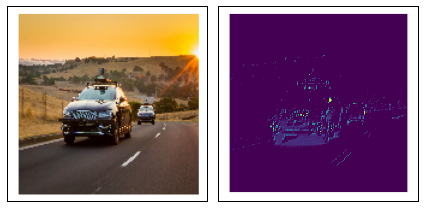

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,3))

ax[0].imshow(img_tensor[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].matshow(activations[0][0, :, :, 0], cmap='viridis') # first layer activation, first filter
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()

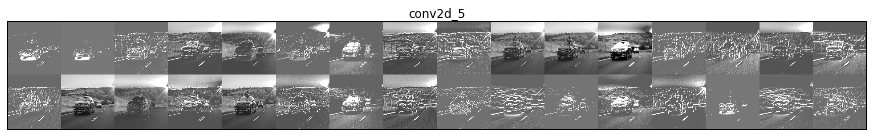

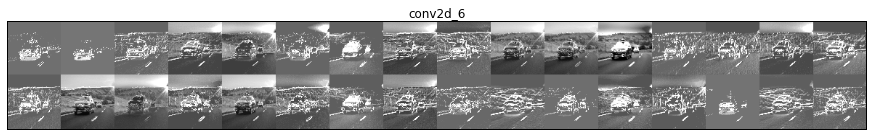

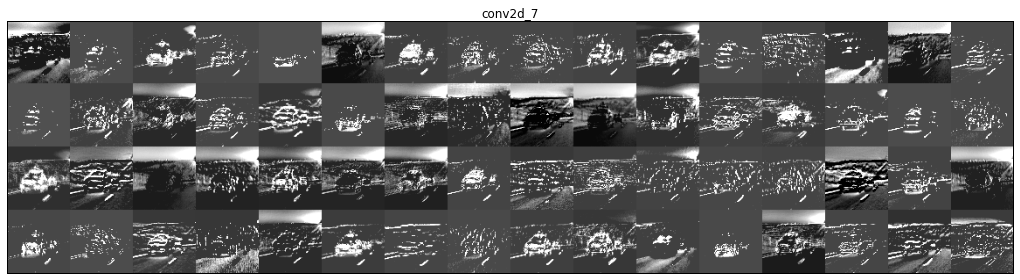

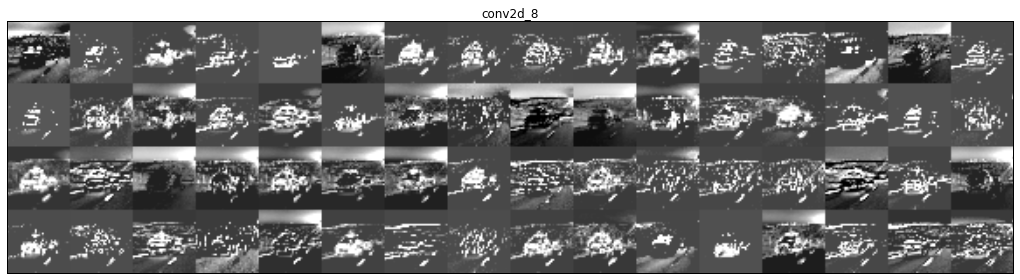

In [12]:
layer_names = []
for layer in model.layers[:vis_layers_num]:
    if 'max_pooling' in layer.name:
        continue
    layer_names.append(layer.name)
images_per_row = 16
# fig, ax = plt.subplots(len(layer_names), figsize = (8, 16))
idx = 0
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, size * images_per_row))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    #     ax[idx].imshow(display_grid, aspect = 'auto', cmap='viridis')
    #     ax[idx].grid(False)
    #     ax[idx].set_xticks([])
    #     ax[idx].set_yticks([])
    #     idx += 1

## Visualization through gradient descent

In [ ]:
from keras.applications import VGG16
from keras import backend as K

In [ ]:
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [ ]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [ ]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [ ]:
from tqdm import tqdm_notebook as tqdm
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(model, layer_name, filter_index, size=150, sgd_steps=50):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    step = 1.
    for i in range(sgd_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    return deprocess_image(input_img_data[0])

In [ ]:
img = generate_pattern(model, 'block3_conv1', 0)
plt.imshow(img);
print img.min(), img.max(), img.mean(), img.shape

In [ ]:
def visualize_layers(model, layer_name, size=64, margin=5, rows=8, cols=8, sgd_steps=50):
    from tqdm import tqdm_notebook as tqdm
    results = np.zeros((rows * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3), dtype=('uint8'))
    for idx in tqdm(range(rows)):
        for jdx in range(cols):
            filter_img = generate_pattern(model, layer_name, idx + (jdx * cols), size=size, sgd_steps=sgd_steps)
            horizontal_start = idx * size + idx * margin
            horizontal_end = horizontal_start + size
            vertical_start = jdx * size + jdx * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
            test = filter_img
    plt.figure(figsize=(10, 10))
    plt.imshow(results)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

visualize_layers(model, 'block1_conv1', sgd_steps=50)

In [ ]:
visualize_layers(model, 'block2_conv1', sgd_steps=50)

In [ ]:
visualize_layers(model, 'block3_conv1', sgd_steps=50)

In [ ]:
visualize_layers(model, 'block4_conv1', sgd_steps=50)